In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
module_path = os.path.join(os.environ['HOME'],'Code/Python')
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize, LinearSegmentedColormap

In [4]:
from taylorDiagram import TaylorDiagram
from statsmodels.nonparametric.smoothers_lowess import lowess

In [5]:
from pydicts.obsdict import get_FINO_obs
from mmctools.helper_functions import theta_to_T, lowess_mean
from mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file

In [6]:
wrf_dir   = '/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/'
cases     = ['ERAI_YSU_KF_CHRN_OST','ERAI_YSU_KF_JMNZ_OST','ERAI_YSU_KF_CHRN_GHR','ERAI_MYN_KF_CHRN_OST']#,'ERA5_YSU_KF_CHRN_OST']

In [7]:
restarts  = ['FINO_2010051212', 'FINO_2010051412', 'FINO_2010051612', 'FINO_2010051812',
             'FINO_2010052012', 'FINO_2010052212', 'FINO_2010052412']
wrf_start = ['2010-05-12 12:00:00', '2010-05-14 12:00:00', '2010-05-16 12:00:00', '2010-05-18 12:00:00',
             '2010-05-20 12:00:00', '2010-05-22 12:00:00', '2010-05-24 12:00:00']
ncases = len(cases)
case_days_start = ['2010-05-13']
case_days_end   = ['2010-05-26']
n_case_days = len(case_days_start)

In [8]:
read_in_obs = True
save_figs   = False

# Get Obs

In [9]:
if read_in_obs:
    obs_dir = '/glade/work/hawbecke/MMC/FINO/'
    obs_year = 2010
    fino_obs = {'FINO1': [],
                'FINO2': [],
                'FINO3': []}
    boom_deg = 345
    for ff, fino in enumerate([1,2,3]):
        print('Getting obs dataset for {}FINO{}/Year{}/'.format(obs_dir,fino,obs_year))
        fino_obs['FINO{}'.format(fino)] = get_FINO_obs('{}FINO{}/Year{}/'.format(obs_dir,fino,obs_year),FINO=fino,boom_deg=boom_deg)

Getting obs dataset for /glade/work/hawbecke/MMC/FINO/FINO1/Year2010/
air_pressure_ at 20.0 m is empty... skipping.
air_pressure_ at 90.0 m is empty... skipping.
no data for air_pressure_
precipitation_ at 33.0 m is empty... skipping.
precipitation_ at 90.0 m is empty... skipping.
no data for precipitation_
humidity_ at 33.0 m is empty... skipping.
humidity_ at 50.0 m is empty... skipping.
no data for humidity_
global_radiation_ at 33.0 m is empty... skipping.
global_radiation_ at 50.0 m is empty... skipping.
no data for global_radiation_
Getting obs dataset for /glade/work/hawbecke/MMC/FINO/FINO2/Year2010/
Getting obs dataset for /glade/work/hawbecke/MMC/FINO/FINO3/Year2010/


# Get WRF towers

### To get towers interpolated to obs levels:

In [10]:
wrf_twrs = {}
for case in cases:
    case_dir = '{}{}/'.format(wrf_dir,case)
    wrf_twrs[case] = {'FN1': [],
                      'FN2': [],
                      'FN3': []}

    for ff, fino in enumerate([1,2,3]):
        twr_path = '{}/FINO{}.nc'.format(case_dir,fino)
        if path.exists(twr_path):
            print('loading in full dataset!')
            wrf_twrs[case]['FN{}'.format(fino)] = xr.open_dataset(twr_path)
        else:
            if read_in_obs:
                obs_ds = fino_obs['FINO{}'.format(fino)]
                obs_levels = np.unique(sorted(np.concatenate([obs_ds.spd_levels.data, obs_ds.dir_levels.data,obs_ds.tmp_levels.data])))
            else:
                if fino == 1:
                    obs_levels = np.asarray([30.,  33.,  40.,  50.,  60.,  70.,  80.,  90., 100.])
                elif fino == 2:
                    obs_levels = np.asarray([30.,  31.,  32.,  40.,  42.,  50.,  51.,  52.,  62.,  70.,  71.,  72.,  82.,  91.,  92.,  99., 102.])
                elif fino == 3:
                    obs_levels = np.asarray([28.,  29.,  30.,  40.,  50.,  55.,  60.,  70.,  80.,  90.,  95.,  100., 106.])
                else:
                    print('fino can only be 1-3')
            wrf_twrs[case]['FN{}'.format(fino)] = tsout_seriesReader(case_dir,restarts,wrf_start,'d03',structure='unordered',
                                                                     time_step=10.0,select_tower=['FN{}'.format(fino)],
                                                                     heights=obs_levels,height_var='ph')
            wrf_twrs[case]['FN{}'.format(fino)].to_netcdf(twr_path)

loading in full dataset!
loading in full dataset!
loading in full dataset!
loading in full dataset!
loading in full dataset!
loading in full dataset!
loading in full dataset!
loading in full dataset!
loading in full dataset!
loading in full dataset!
loading in full dataset!
loading in full dataset!


In [11]:
wake_degs = {'FINO1': [300,335],
             'FINO2': [345,20],
             'FINO3': [143,188]}

/glade/u/home/hawbecke/local/envs/pyhawbeck/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


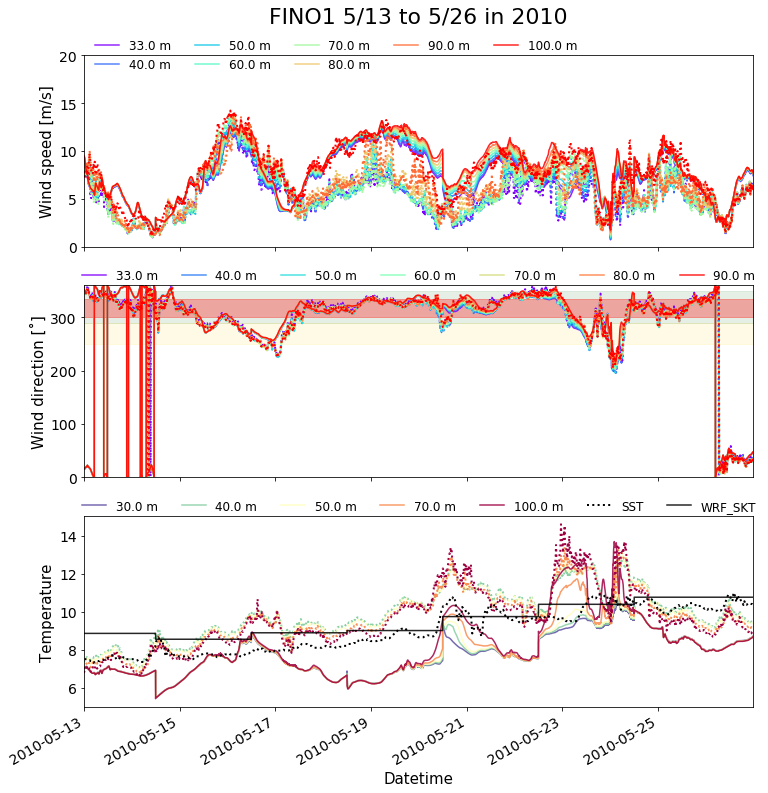

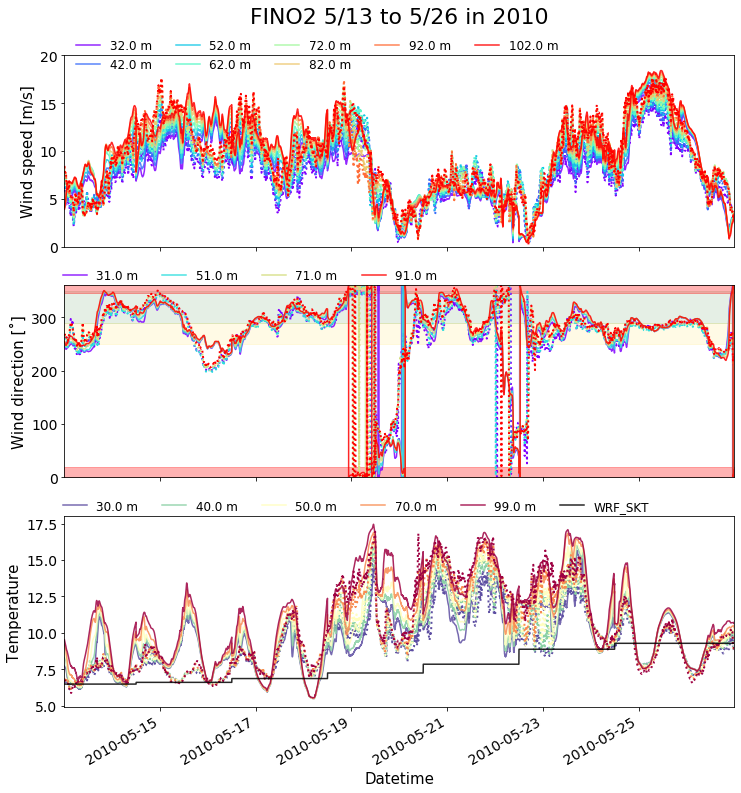

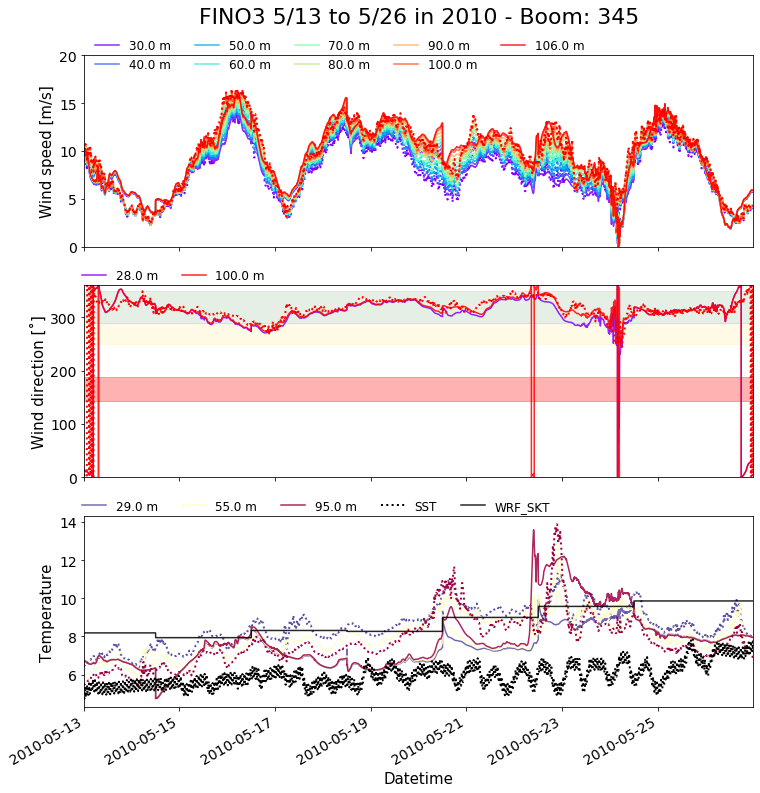

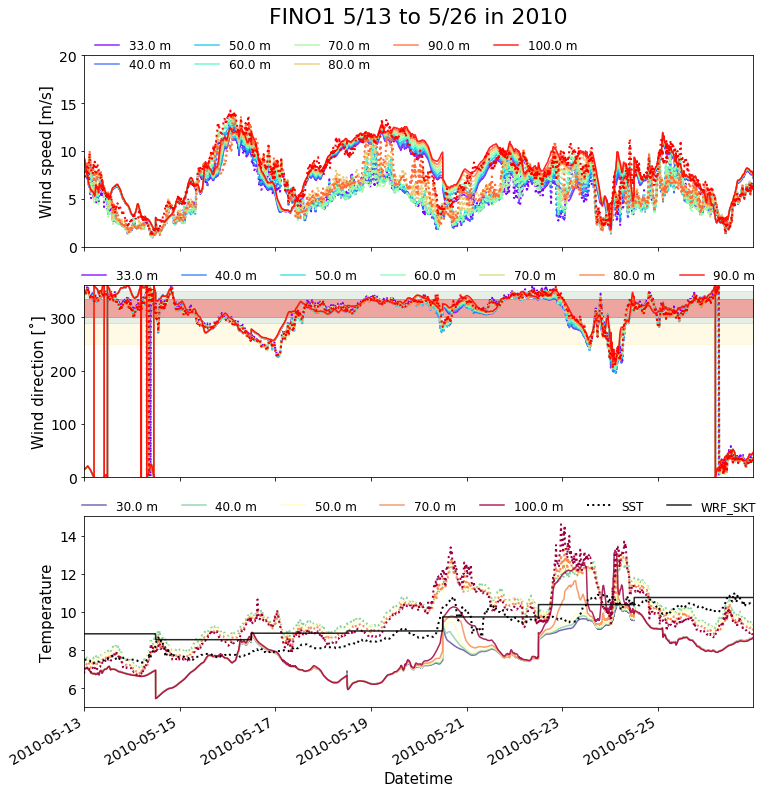

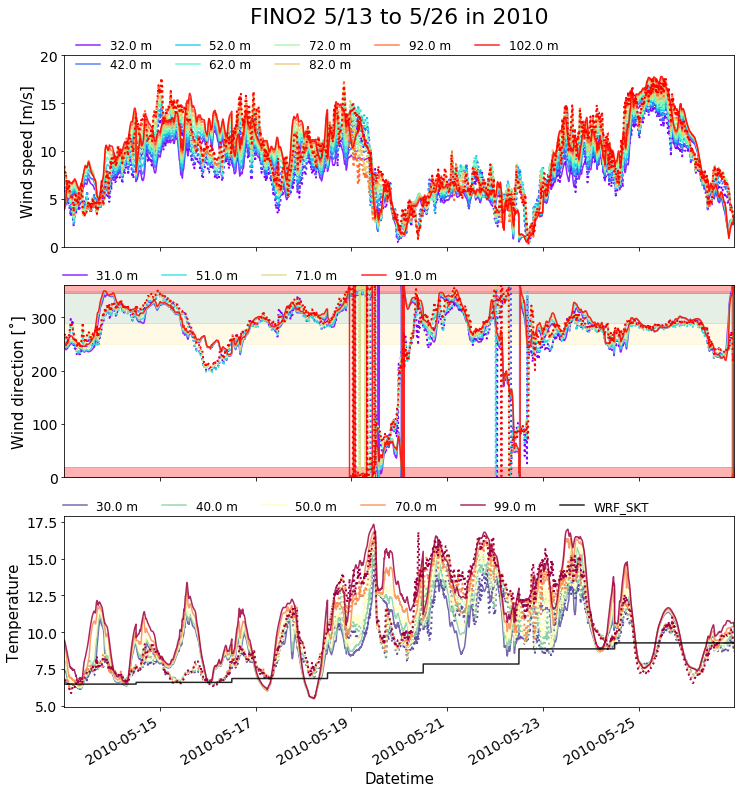

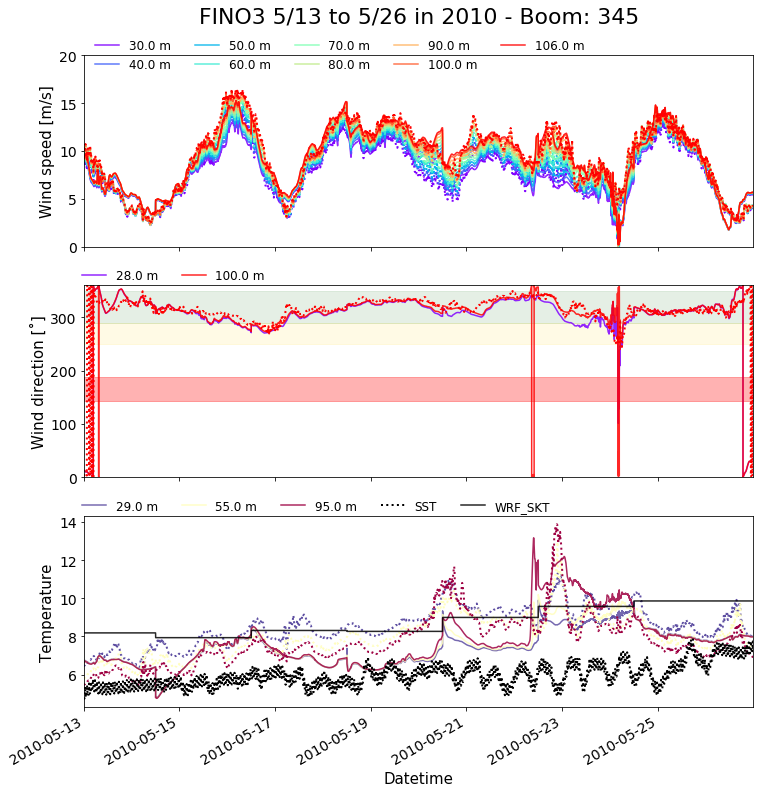

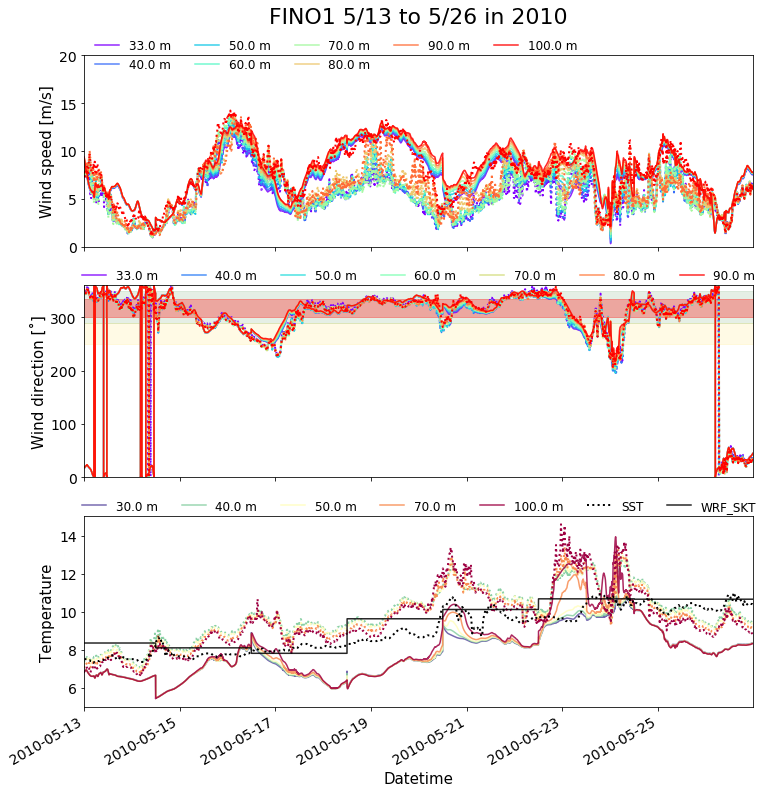

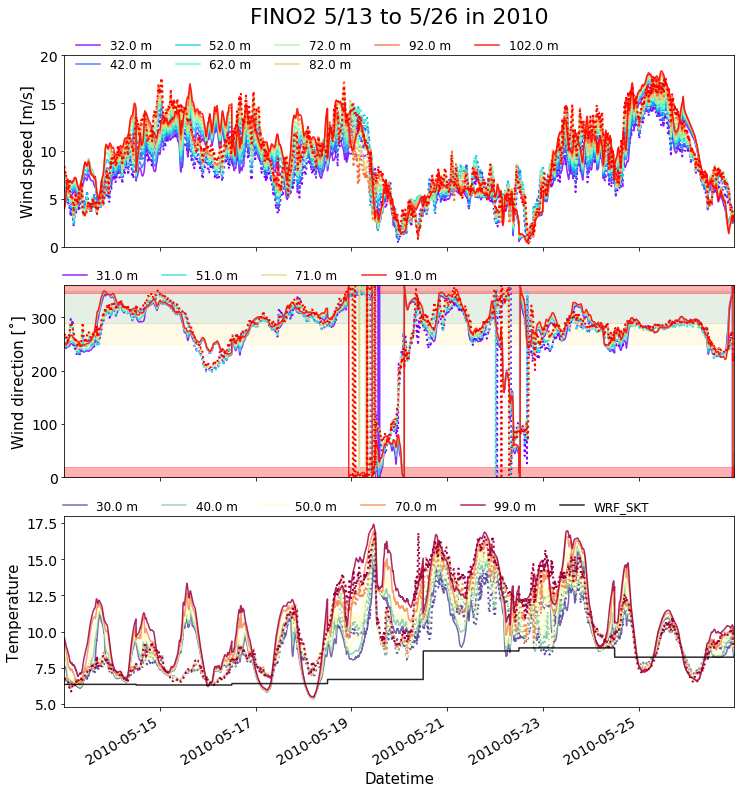

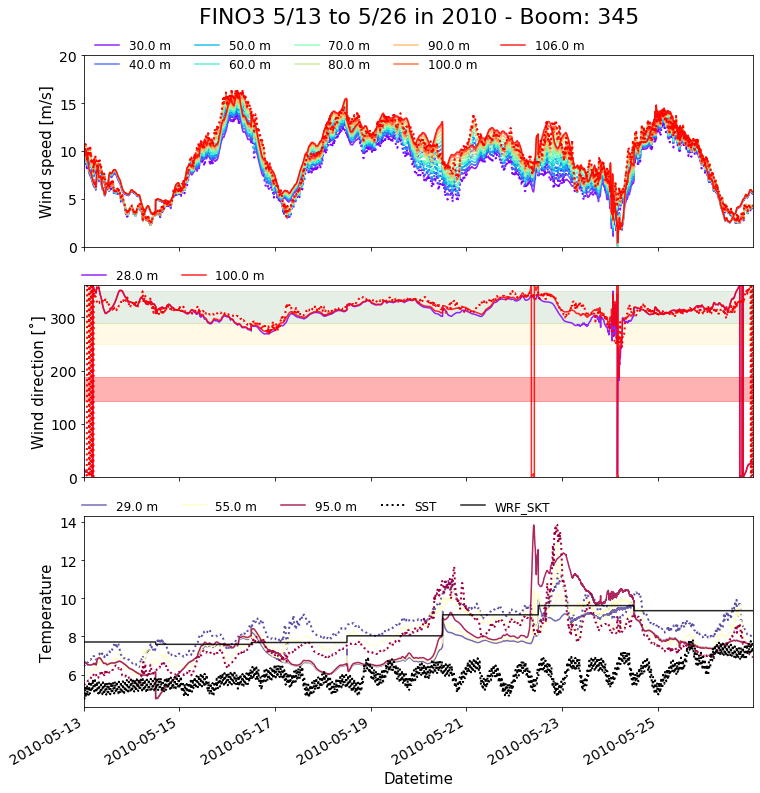

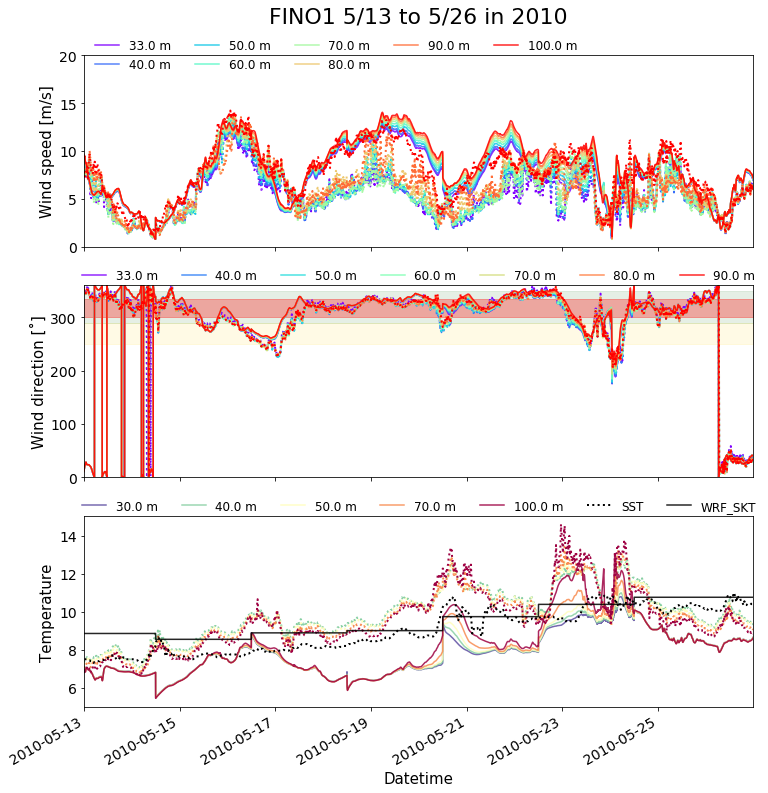

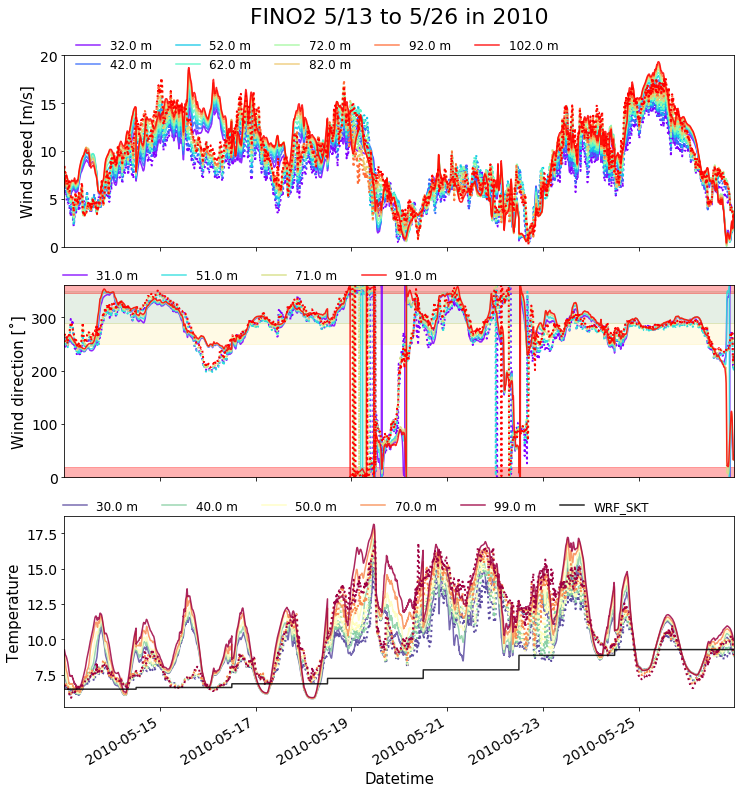

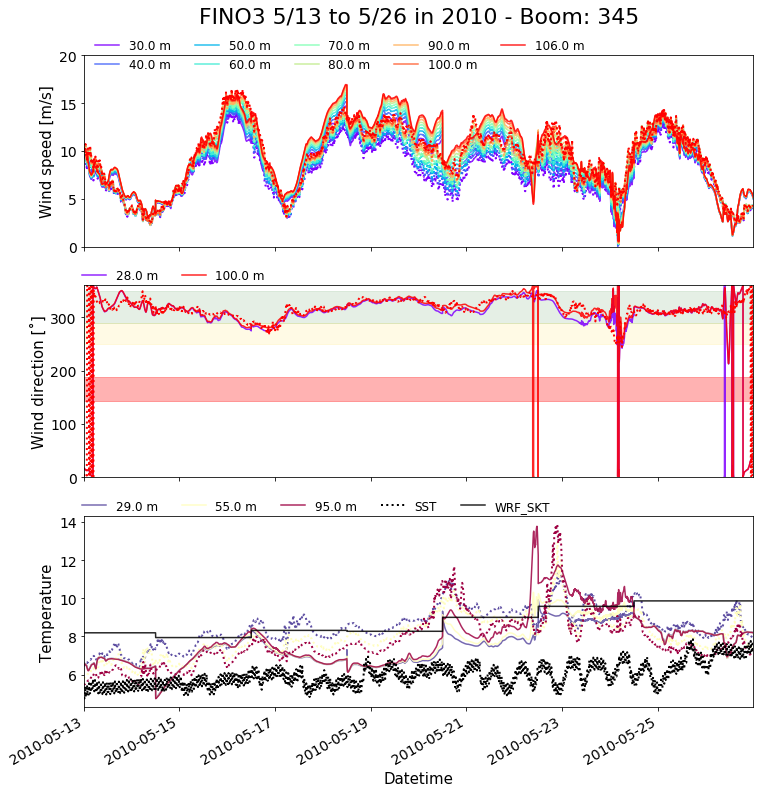

In [12]:
for cc,case in enumerate(cases):
    case_dir = '{}{}/'.format(wrf_dir,case)
    for ff, fino in enumerate([1,2,3]):
        fig,ax = plt.subplots(nrows=3,figsize=(12,12),sharex=True)

        obs_ds = fino_obs['FINO{}'.format(fino)]
        period = obs_ds.sel(datetime=slice(case_days_start[0],case_days_end[0]))
        twr_ds = wrf_twrs[case]['FN{}'.format(fino)]
        levels = twr_ds.ph.data[0,:,0]

        # ============================================= #
        # ============= WIND SPEED PLOT =============== #
        plt_levels = period.spd_levels.values
        n_plt_lvls = len(plt_levels)

        plt_colors=plt.cm.rainbow(np.linspace(0,1,n_plt_lvls))

        for vv,lvl in enumerate(plt_levels):
            wlvl = np.where(levels==lvl)[0][0]
            wspd_plt = period.wspd.sel(spd_levels=lvl).dropna(how='all',dim='datetime')
            if len(wspd_plt) > 1:
                wspd_plt.plot(ax=ax[0],c=plt_colors[vv],ls=':',lw=2.0)#,label='{0:2.1f} m'.format(lvl))

            wspd_plt = twr_ds.wspd.sel(nz=wlvl)
            if len(wspd_plt) > 1:
                wspd_plt.plot(ax=ax[0],label='{0:2.1f} m'.format(lvl),c=plt_colors[vv],alpha=0.85)
        # ============================================= #
        # ============= WIND DIREC PLOT =============== #
        plt_levels = period.dir_levels.values
        n_plt_lvls = len(plt_levels)

        plt_colors=plt.cm.rainbow(np.linspace(0,1,n_plt_lvls))

        for vv,lvl in enumerate(plt_levels):
            clvl = np.where(plt_levels==lvl)[0][0]
            wlvl = np.where(levels==lvl)[0][0]
            wdir_plt = period.wdir.sel(dir_levels=lvl).dropna(how='all',dim='datetime')
            if len(wdir_plt) > 1:
                wdir_plt.plot(ax=ax[1],c=plt_colors[vv],ls=':',lw=2.0)#,label='{0:2.1f} m'.format(lvl))

            wdir_plt = twr_ds.wdir.sel(nz=wlvl)
            if len(wdir_plt) > 1:
                wdir_plt.plot(ax=ax[1],label='{0:2.1f} m'.format(lvl),c=plt_colors[vv],alpha=0.85)
        # ============================================= #
        # ============= TEMPERATURE PLOT ============== #
        plt_levels = period.tmp_levels.values
        n_plt_lvls = len(plt_levels)


        plt_colors=plt.cm.Spectral_r(np.linspace(0,1,n_plt_lvls))            
        for vv,lvl in enumerate(plt_levels): 
            wlvl = np.where(levels==lvl)[0][0]
            tmp_plt = period.temp.sel(tmp_levels=lvl).dropna(how='all',dim='datetime')
            if len(tmp_plt) > 1:
                tmp_plt.plot(ax=ax[2],c=plt_colors[vv],ls=':',lw=2.0)#,label='{0:2.1f} m'.format(lvl)

            tmp_plt = twr_ds.theta.sel(nz=wlvl)-273.15
            if len(tmp_plt) > 1:
                tmp_plt.plot(ax=ax[2],label='{0:2.1f} m'.format(lvl),c=plt_colors[vv],alpha=0.85)
        sst_data = True
        try:
            sst_plt = period.sst.dropna(dim='datetime',how='any')
        except:
            sst_data = False
        if sst_data:
            if len(sst_plt.values[0]) > 1:
                sst_plt.plot(ax=ax[2],c='k',label='SST',lw=2.0,ls=':')

        (twr_ds.tsk-273.15).plot(c='k',alpha=0.85,label='WRF_SKT')




        # --------- Wind Speed Adjustments ---------- #
        plt_start_date = pd.to_datetime(period.datetime.values[0])
        plt_end_date = pd.to_datetime(period.datetime.values[-1])
        if fino == 3:
            ax[0].set_title('FINO{} {}/{} to {}/{} in {} - Boom: {}'.format(fino,plt_start_date.month,
                                                plt_start_date.day,plt_end_date.month,plt_end_date.day,
                                                plt_end_date.year,boom_deg),size=22,y=1.14)
        else:
            ax[0].set_title('FINO{} {}/{} to {}/{} in {}'.format(fino,plt_start_date.month,plt_start_date.day,
                                                plt_end_date.month,plt_end_date.day,plt_end_date.year),
                                                size=22,y=1.14)
        ax[0].set_xlabel('')
        ax[0].tick_params(labelsize=14)
        ax[0].set_ylabel('Wind speed [m/s]',size=15)
        ax[0].set_ylim(0,20)
        ax[0].set_xlim(period.datetime.values[0],period.datetime.values[-1])
        leg_loc = 0.89
        ax[0].legend(frameon=False,loc=(0.01,leg_loc),ncol=5,fontsize=12)

        # --------- Wind Direction Adjustments --------- #
        ax[1].legend(frameon=False,loc=(-0.01,0.99),ncol=7,fontsize=12)
        ax[1].set_ylim(0,360)
        ax[1].set_xlabel('')
        ax[1].set_xlim(period.datetime.values[0],period.datetime.values[-1])
        ax[1].fill_between([period.datetime.values[0],period.datetime.values[-1]],290,350,color='darkgreen',alpha=0.1)
        ax[1].fill_between([period.datetime.values[0],period.datetime.values[-1]],250,290,color='gold',alpha=0.1)
        ax[1].set_title('')
        ax[1].tick_params(labelsize=14)
        ax[1].set_ylabel('Wind direction [˚]',size=15)
        if fino == 2: 
            ax[1].fill_between([period.datetime.values[0],period.datetime.values[-1]],
                               wake_degs['FINO{}'.format(fino)][0],360,color='red',alpha=0.3)
            ax[1].fill_between([period.datetime.values[0],period.datetime.values[-1]],
                               0.0,wake_degs['FINO{}'.format(fino)][1],color='red',alpha=0.3)
        else:
            ax[1].fill_between([period.datetime.values[0],period.datetime.values[-1]],
                               wake_degs['FINO{}'.format(fino)][0],wake_degs['FINO{}'.format(fino)][1],
                               color='red',alpha=0.3)

        # --------- Temperature Adjustments --------- #
        #ax[2].set_ylim(0,360)
        ax[2].set_xlim(period.datetime.values[0],period.datetime.values[-1])
        ax[2].set_title('')
        ax[2].tick_params(labelsize=14)
        ax[2].set_ylabel('Temperature',size=15)
        ax[2].set_xlabel('Datetime',size=15)
        ax[2].legend(frameon=False,loc=(-0.01,0.99),ncol=7,fontsize=12)
        # -------------------------------------------- #

        # Save the figures:
        if fino==3:
            savestr = '{}img/case_day_{}_FINO{}_boomdeg{}.png'.format(case_dir,case_days_start[0],fino,boom_deg)
        else:
            savestr = '{}img/case_day_{}_FINO{}.png'.format(case_dir,case_days_start[0],fino)
        if save_figs: plt.savefig(savestr)

        plt.show()
        print('\n\n\n\n')

### Check SST Differences

/glade/u/home/hawbecke/local/envs/pyhawbeck/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


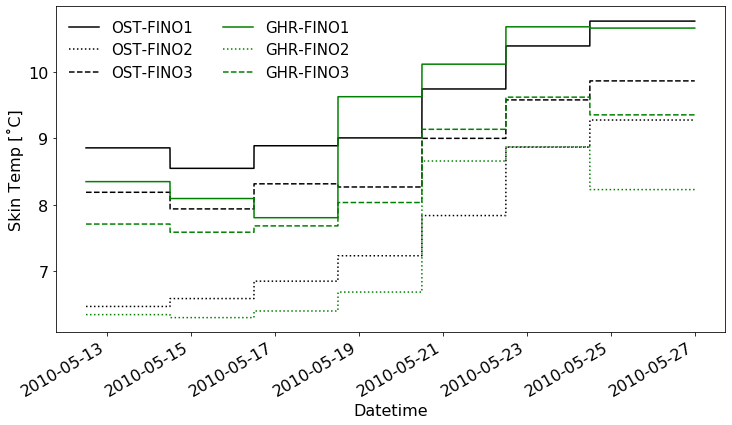

In [14]:
case_c = ['k','g']
twr_st = ['-',':','--']
plt.figure(figsize=(12,6))
for cc,case in enumerate(cases[1:3]):
    case_dir = '{}{}/'.format(wrf_dir,case)
    for ff, fino in enumerate([1,2,3]):
        twr_ds = wrf_twrs[case]['FN{}'.format(fino)]
        (twr_ds.tsk-273.15).plot(ls=twr_st[ff],c=case_c[cc],label='{}-FINO{}'.format(case[-3:],fino))
plt.legend(frameon=False,fontsize=15,ncol=2)
plt.tick_params(labelsize=16)
plt.ylabel('Skin Temp [˚C]',size=16)
plt.xlabel('Datetime',size=16)
plt.show()

In [15]:
case_colors = ['red','blue','green','m']
case_style  = ['-','--',':','-.']

In [16]:
remove_mean = False
remove_wake = True

# Wind Speed Taylor Diagrams

/glade/u/home/hawbecke/local/envs/pyhawbeck/lib/python3.7/site-packages/xarray/core/resample.py:174: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)


/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526//img/TD_data_FINO1_nowake


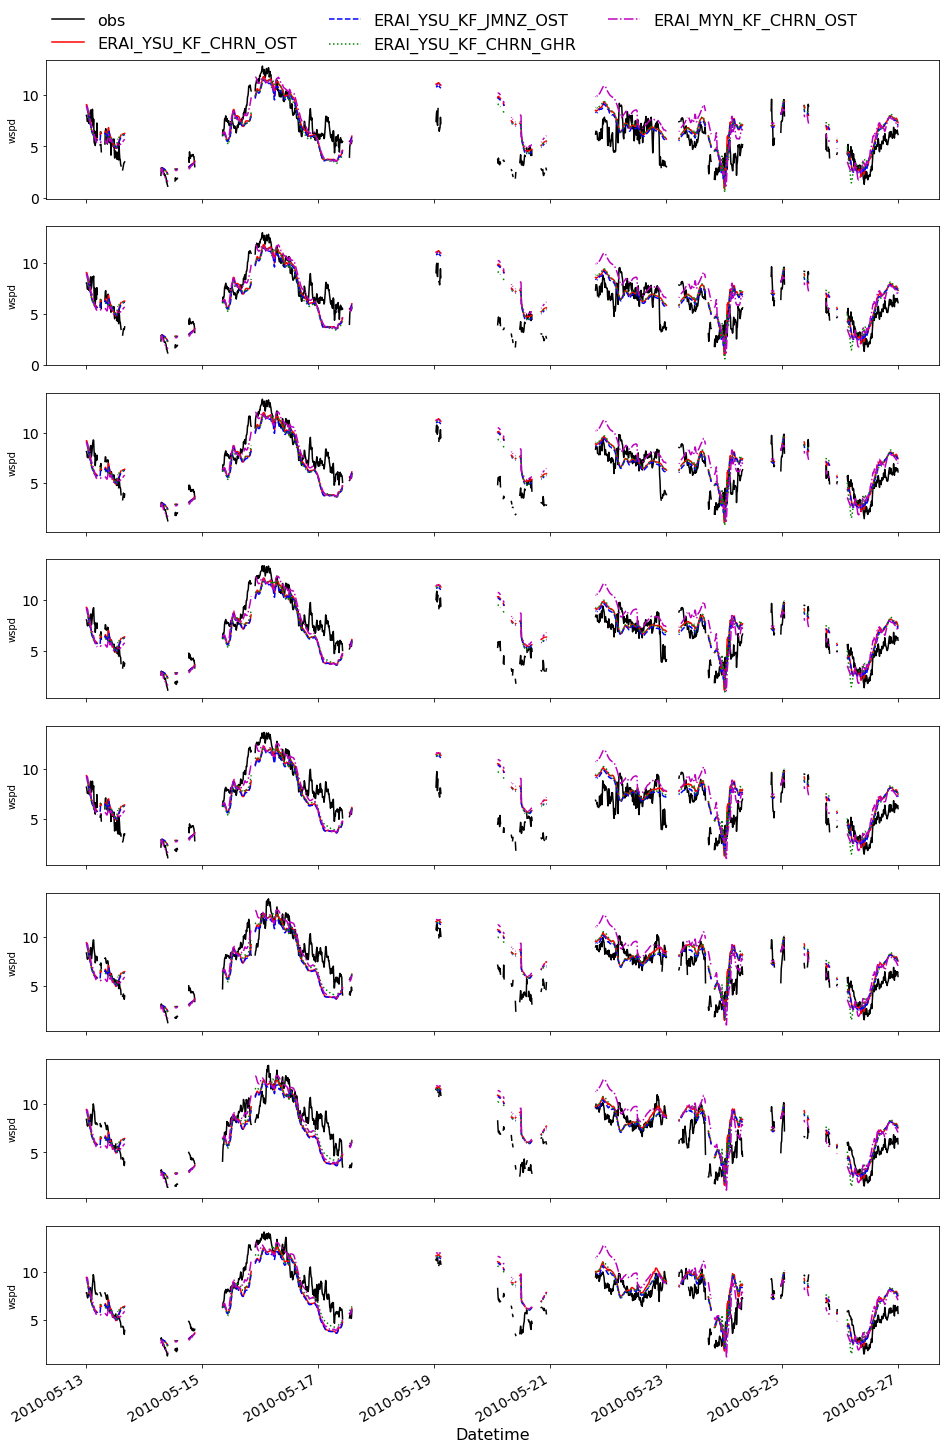

/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526//img/TD_FINO1_nowake


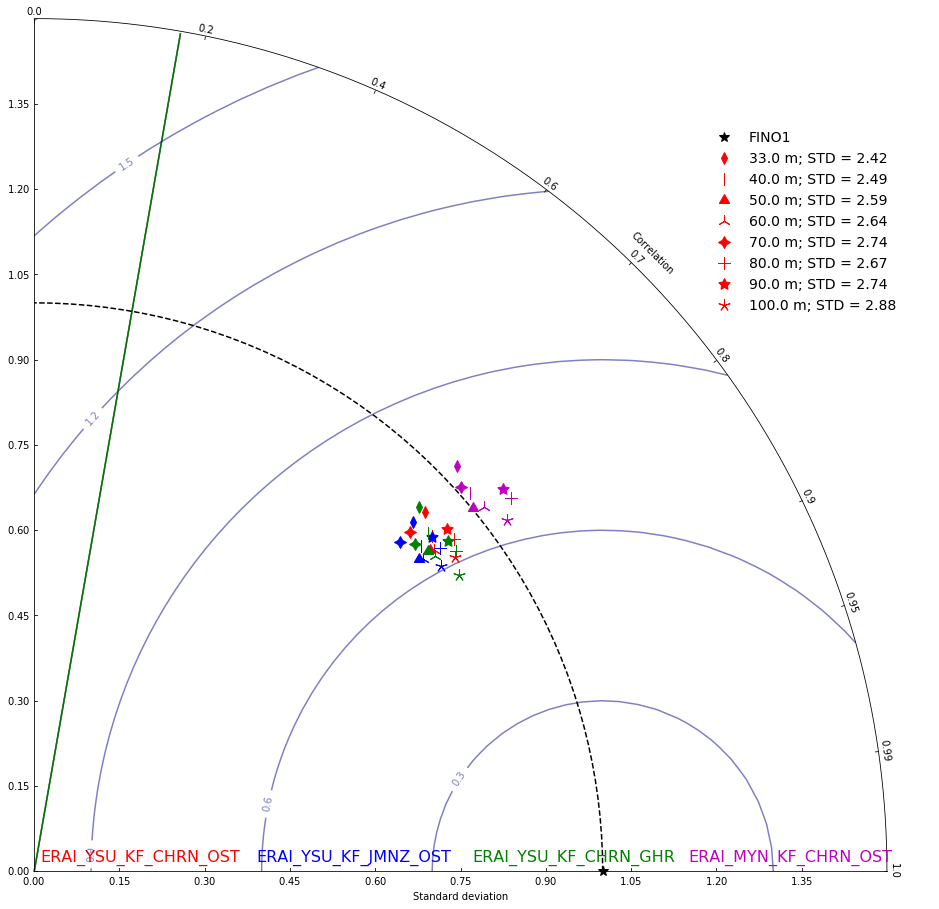

/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526//img/TD_data_FINO2_nowake


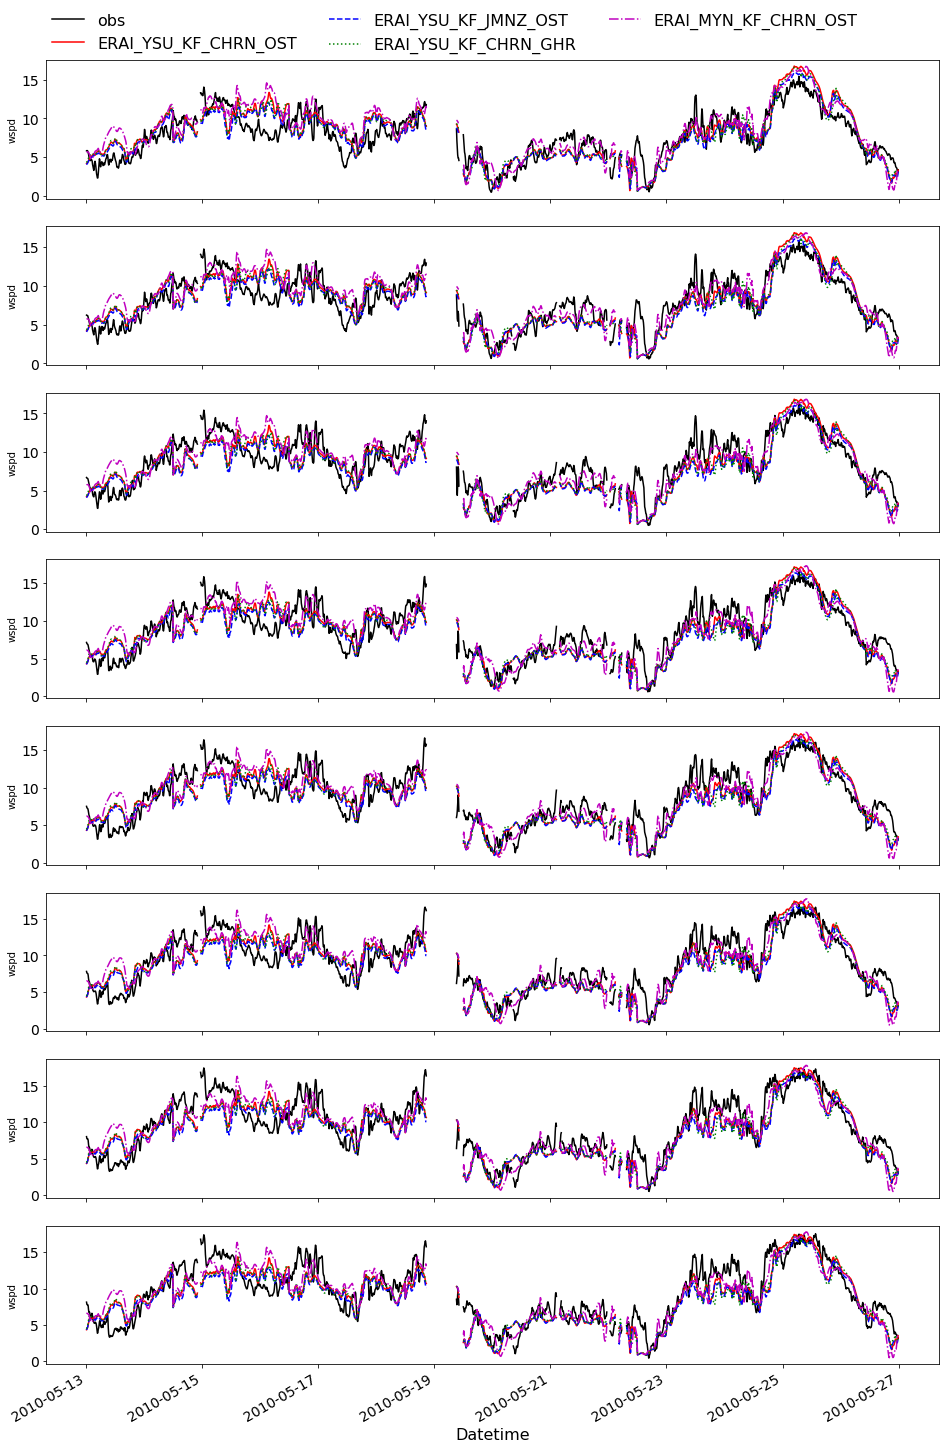

/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526//img/TD_FINO2_nowake


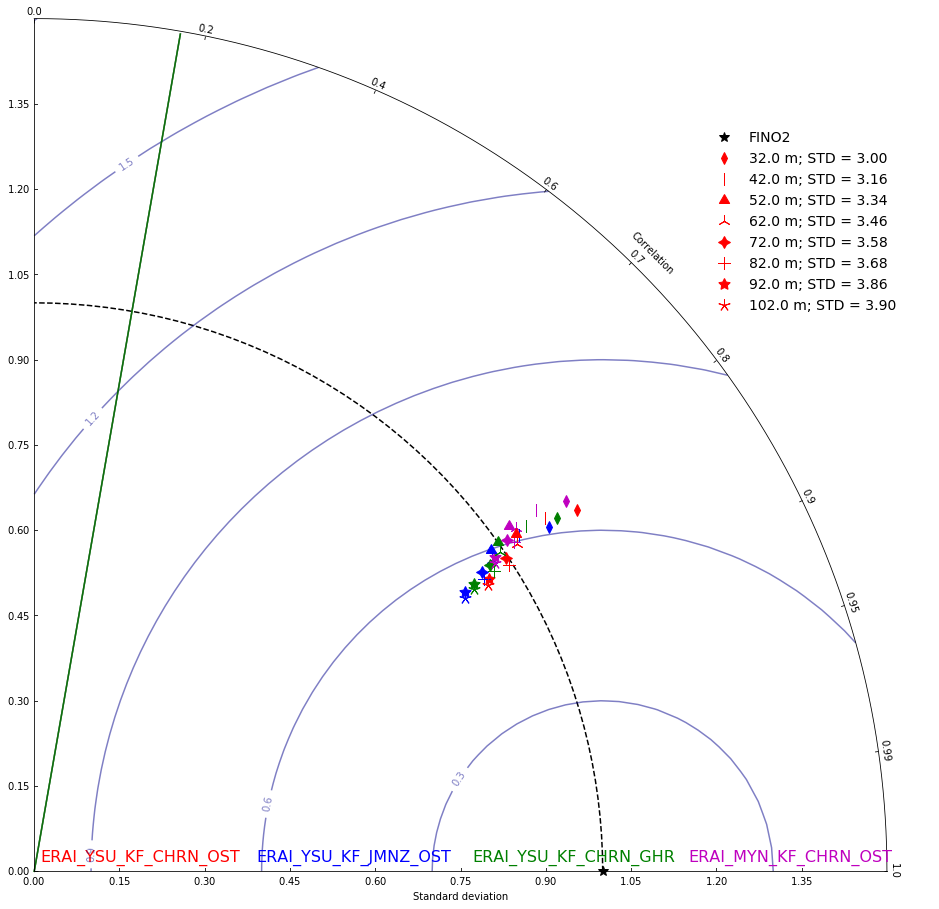

/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526//img/TD_data_FINO3_nowake


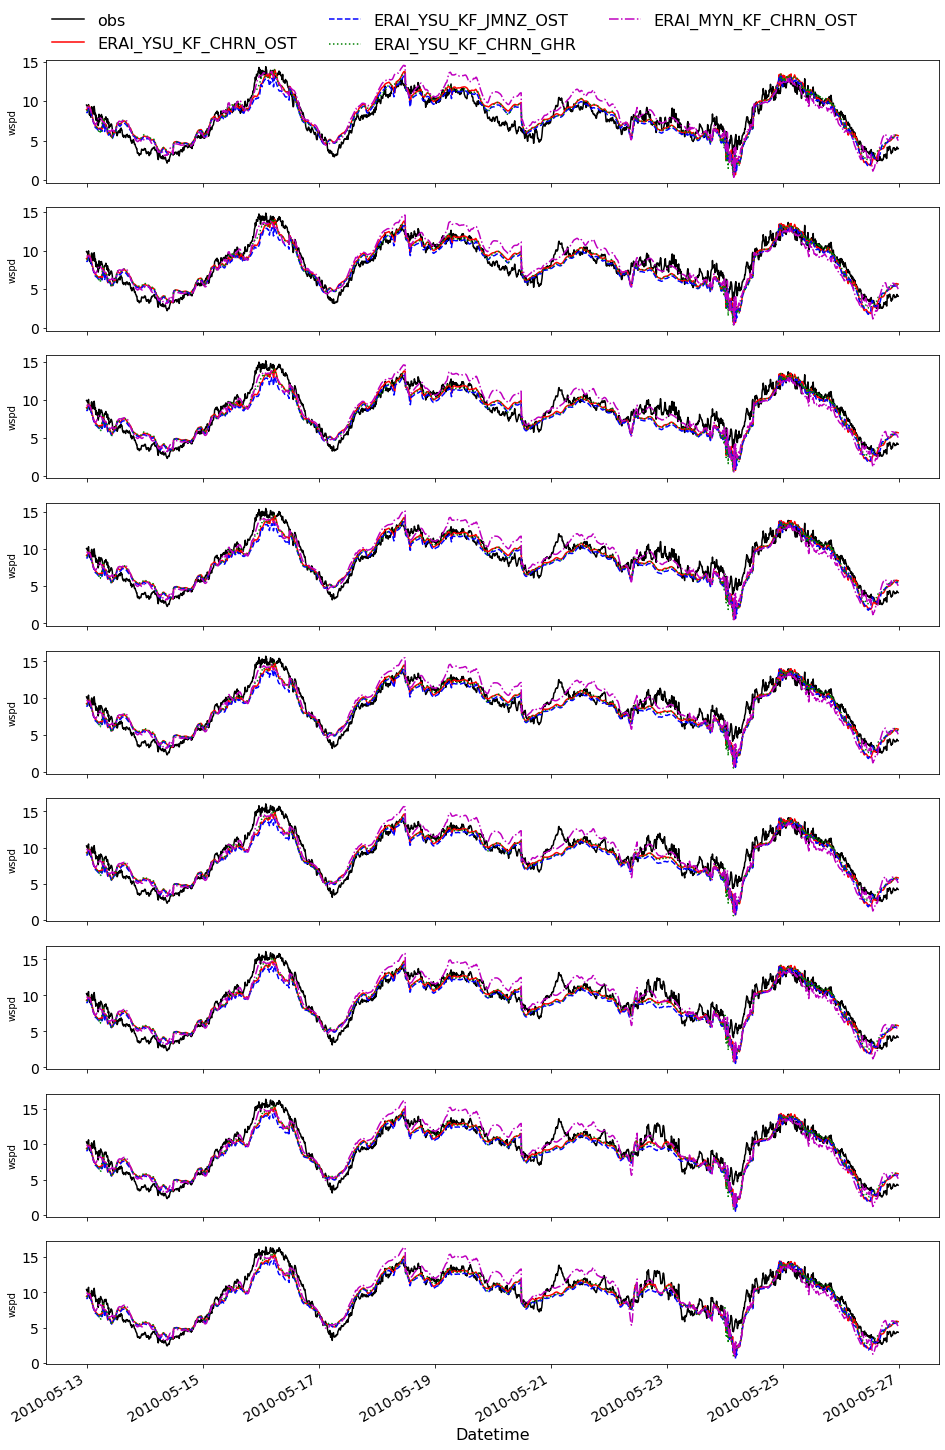

/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526//img/TD_FINO3_nowake


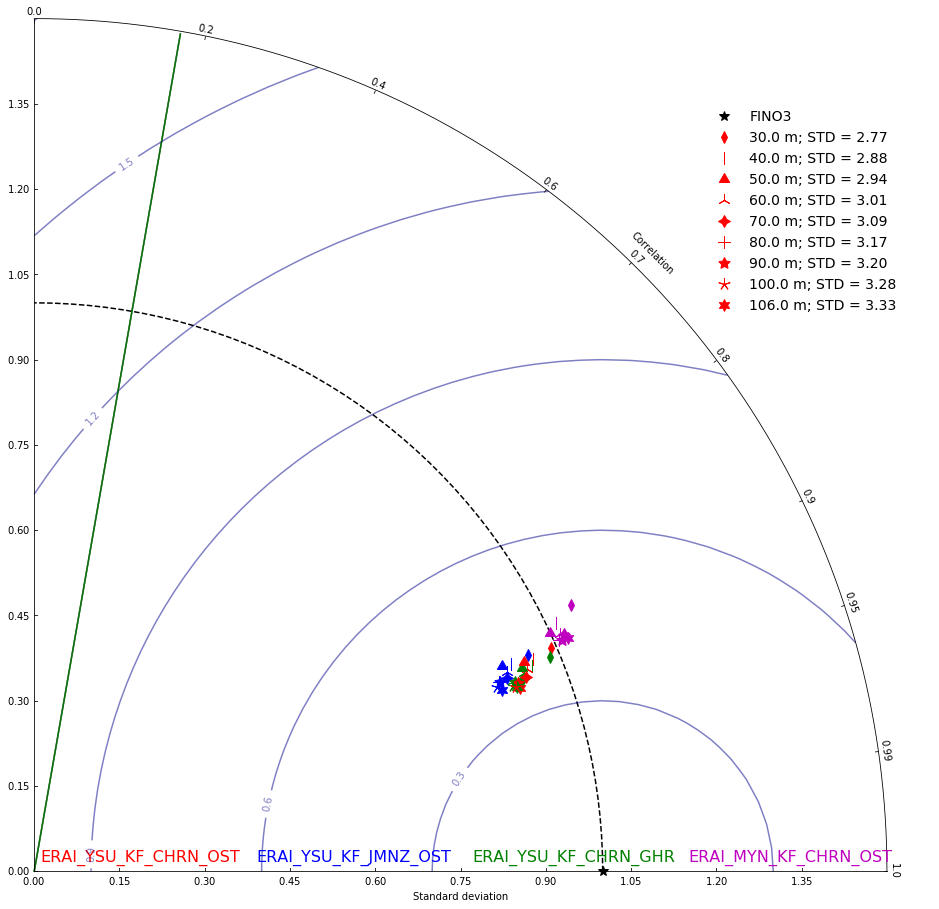

In [17]:
for ff, fino in enumerate([1,2,3]):
    obs_ds = fino_obs['FINO{}'.format(fino)]
    levels = obs_ds.spd_levels.values
    obs_wdir = obs_ds.wdir
    max_pts = 0
    dir_lvl = 0
    for vv,lvl in enumerate(obs_wdir.dir_levels.values):
        dir_lvl = obs_wdir.sel(dir_levels=lvl).dropna(how='all',dim='datetime')
        num_pts = len(dir_lvl)
        if num_pts > max_pts:
            dir_lvl = lvl
    
    tay_obs_levels = [[[]]*len(levels)][0]
    ref_std_levels = np.zeros((ncases,len(levels)))
    sim_std_levels = np.zeros((ncases,len(levels)))
    sim_cor_levels = np.zeros((ncases,len(levels)))
    fig,ax = plt.subplots(nrows=len(levels),figsize=(16,24),sharex=True)
    for cc,case in enumerate(cases):
        twr_ds = wrf_twrs[case]['FN{}'.format(fino)]
        tay_wrf_levels = [[[]]*len(levels)][0]

        for vv,lvl in enumerate(levels):
            if cc == 0:
                tay_obs_levels[vv] = obs_ds.wspd.sel(datetime=slice(case_days_start[0],case_days_end[0]),spd_levels=lvl).dropna(
                                                    how='all',dim='datetime').resample(datetime='10min').interpolate('linear')
                if remove_wake:
                    obs_wdir = obs_ds.wdir.sel(datetime=slice(case_days_start[0],case_days_end[0]),dir_levels=dir_lvl).dropna(
                                                    how='all',dim='datetime').resample(datetime='10min').nearest()
                    wake_spd = tay_obs_levels[vv].copy()
                    if fino == 2:
                        wake_spd[np.where((obs_wdir.data >= wake_degs['FINO{}'.format(fino)][0]) | \
                                          (obs_wdir.data <= wake_degs['FINO{}'.format(fino)][1]))] = np.nan
                    else:
                        wake_spd[np.where((obs_wdir.data >= wake_degs['FINO{}'.format(fino)][0]) & \
                                          (obs_wdir.data <= wake_degs['FINO{}'.format(fino)][1]))] = np.nan
                    tay_obs_levels[vv] = wake_spd

            tay_wrf_levels[vv] = twr_ds.wspd.sel(datetime=slice(case_days_start[0],case_days_end[0]),nz=vv).dropna(
                                                how='all',dim='datetime').resample(datetime='10min').mean()
            if remove_wake:
                wake_spd = tay_wrf_levels[vv].copy()
                wake_spd[np.where(np.isnan(tay_obs_levels[vv]))] = np.nan
                tay_wrf_levels[vv] = wake_spd

            obs = tay_obs_levels[vv]
            sim = tay_wrf_levels[vv]

            sim[np.where(np.isnan(obs))] = np.nan

            obs = obs.dropna(dim='datetime',how='all')
            sim = sim.dropna(dim='datetime',how='all')

            if remove_mean:
                obs = obs - lowess_mean(obs,2016/32,0)
                sim = sim - lowess_mean(sim,2016/32,0)

            if cc == 0: 
                obs.resample(datetime='10min').asfreq().plot(ax=ax[vv],c='k',label='obs')
            sim.resample(datetime='10min').asfreq().plot(ax=ax[vv],c=case_colors[cc],label=case,ls=case_style[cc])
            ax[vv].tick_params(labelsize=14)
            if vv == len(levels)-1:
                ax[vv].set_xlabel('Datetime',size=16)
            else:
                ax[vv].set_xlabel('')
            if remove_mean: ax[vv].set_ylim(-5,5)

            ref_std_levels[cc,vv] = np.std(obs.data)
            sim_std_levels[cc,vv] = np.std(sim.data)
            sim_cor_levels[cc,vv] = np.corrcoef(sim,obs)[0,1]
    ax[0].legend(frameon=False,loc=(0.0,1.0),ncol=3,fontsize=16)
    save_str = '{}/img/TD_data_FINO{}'.format(wrf_dir,fino)
    if remove_mean: save_str += '_pert'
    if remove_wake: save_str += '_nowake'
    print(save_str)
    plt.savefig('{}.png'.format(save_str))
    plt.show()
    


    fig_tay = plt.figure(figsize=(16,16))    
    dia = TaylorDiagram(1.0, fig=fig_tay, extend=False,
                            label='FINO{}'.format(fino))
    for cc,case in enumerate(cases):
        twr_dict = {}
        for a,b,c,d in zip(range(0,len(levels)),sim_std_levels[cc,:]/ref_std_levels[cc,:],sim_cor_levels[cc,:],levels):
            twr_dict[a] = [b,c,'{} m'.format(d)]



        x95 = [0.0, 0.89*(np.pi/2)]
        y95 = [0.0, 1.495]

        dia.ax.plot(x95,y95,color='darkgreen',alpha=0.5)
        markers = [(i,j,0) for i in range(2,len(levels)+2) for j in range(1, 3)]

        for ii,item in enumerate(twr_dict):
            point = twr_dict[item]
            if cc == 0:
                pt_label = '{0}; STD = {1:1.2f}'.format(point[2],ref_std_levels[cc,ii])
            else:
                pt_label = None
            dia.add_sample(point[0], point[1],
                           marker=markers[item], ms=12, ls='',
                           mfc=case_colors[cc], mec=case_colors[cc], # Colors
                           label=pt_label,
                           zorder=4)
        plt.text(0.01+0.38*cc,0.01,case,color=case_colors[cc],ha='left',va='bottom',size=16)

    contours = dia.add_contours(levels=5, colors='darkblue',alpha=0.5)
    dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    fig_tay.legend(frameon=False,loc=(0.75,0.65),fontsize=14)
    save_str = '{}/img/TD_FINO{}'.format(wrf_dir,fino)
    if remove_mean: save_str += '_pert'
    if remove_wake: save_str += '_nowake'
    print(save_str)
    if save_figs: plt.savefig('{}.png'.format(save_str))
    plt.show()
    
    

# Temperature TDs

/glade/u/home/hawbecke/local/envs/pyhawbeck/lib/python3.7/site-packages/xarray/core/resample.py:174: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/glade/u/home/hawbecke/local/envs/pyhawbeck/lib/python3.7/site-packages/xarray/core/resample.py:174: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/glade/u/home/hawbecke/local/envs/pyhawbeck/lib/python3.7/site-packages/xarray/core/resample.py:174: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/

/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526//img/TD_data_FINO1_T_nowake


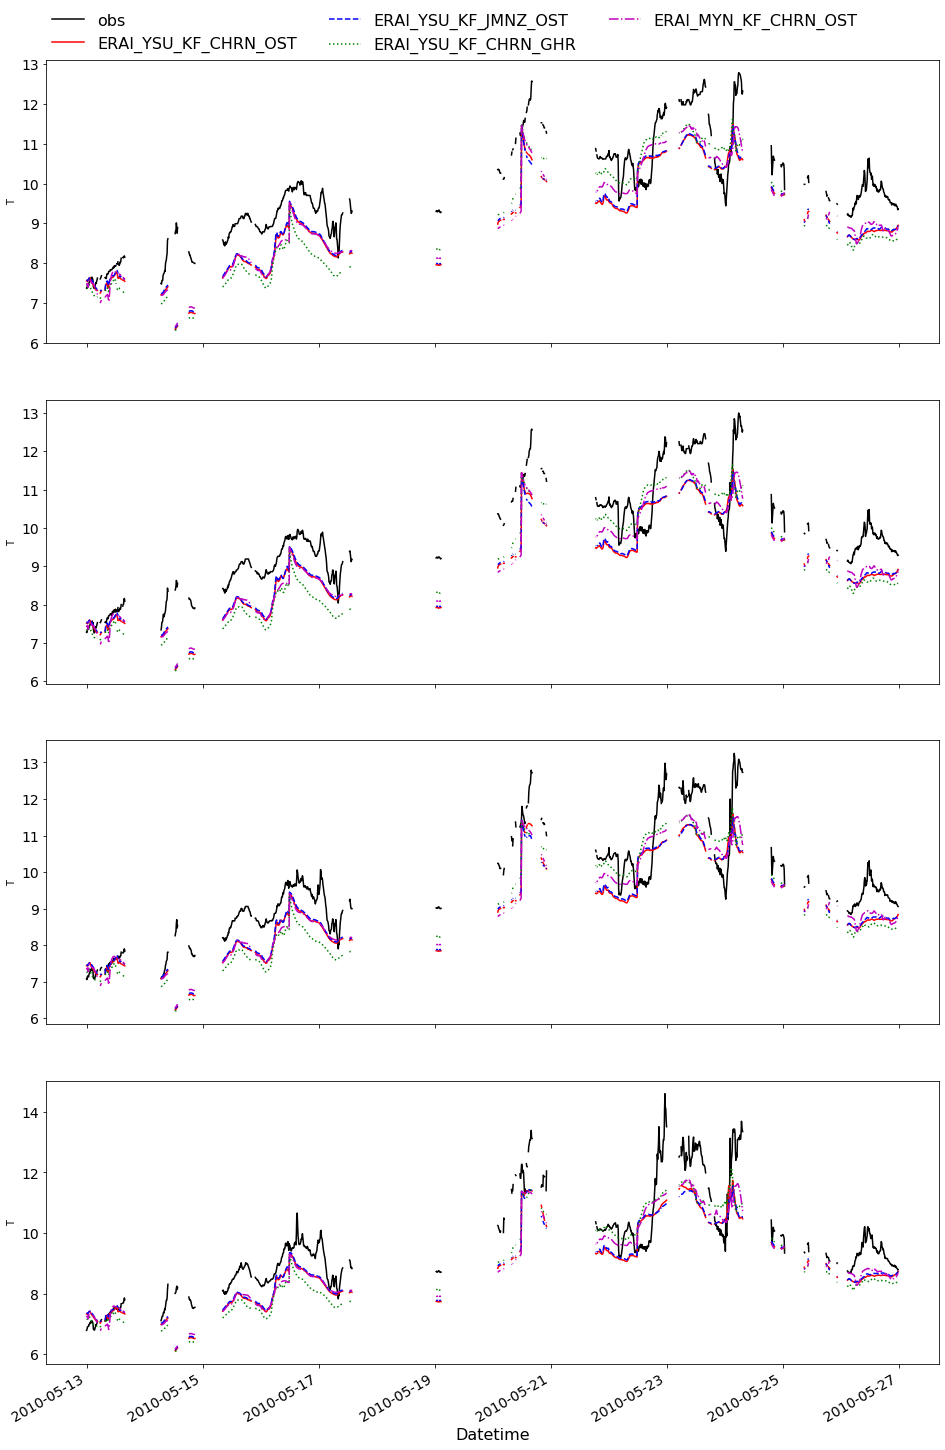

/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526//img/TD_FINO1_T_nowake


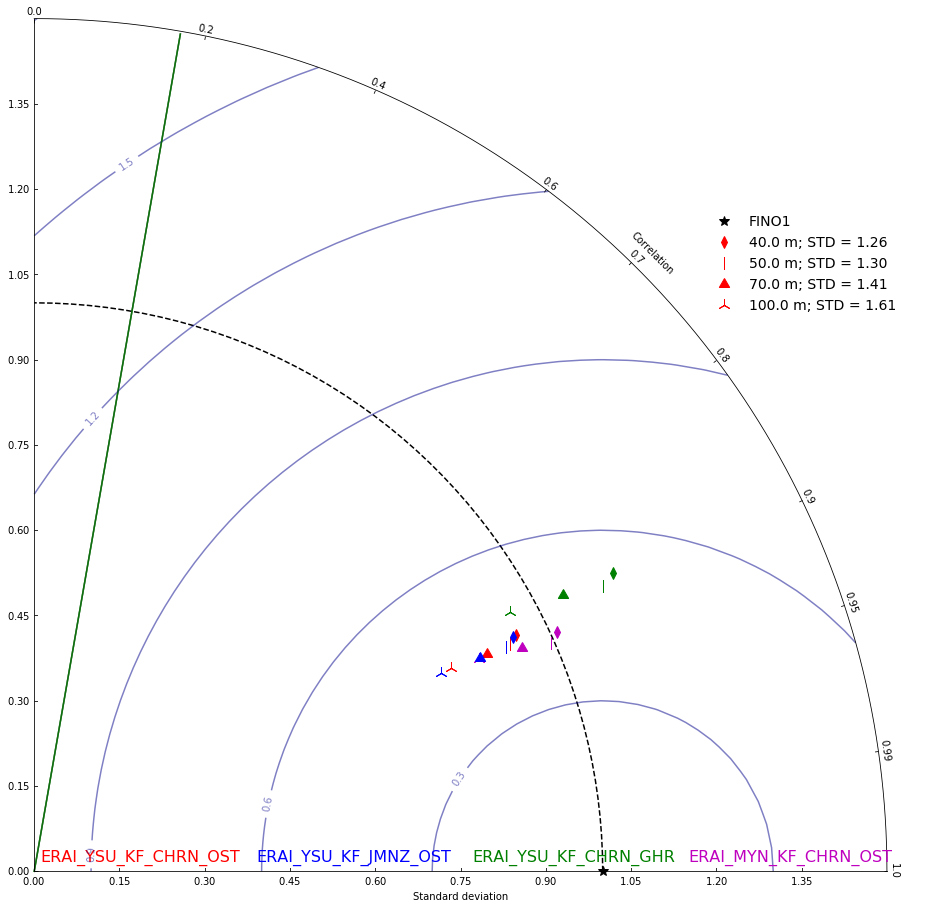

/glade/u/home/hawbecke/local/envs/pyhawbeck/lib/python3.7/site-packages/xarray/core/resample.py:174: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/glade/u/home/hawbecke/local/envs/pyhawbeck/lib/python3.7/site-packages/xarray/core/resample.py:174: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/glade/u/home/hawbecke/local/envs/pyhawbeck/lib/python3.7/site-packages/xarray/core/resample.py:174: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/

/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526//img/TD_data_FINO2_T_nowake


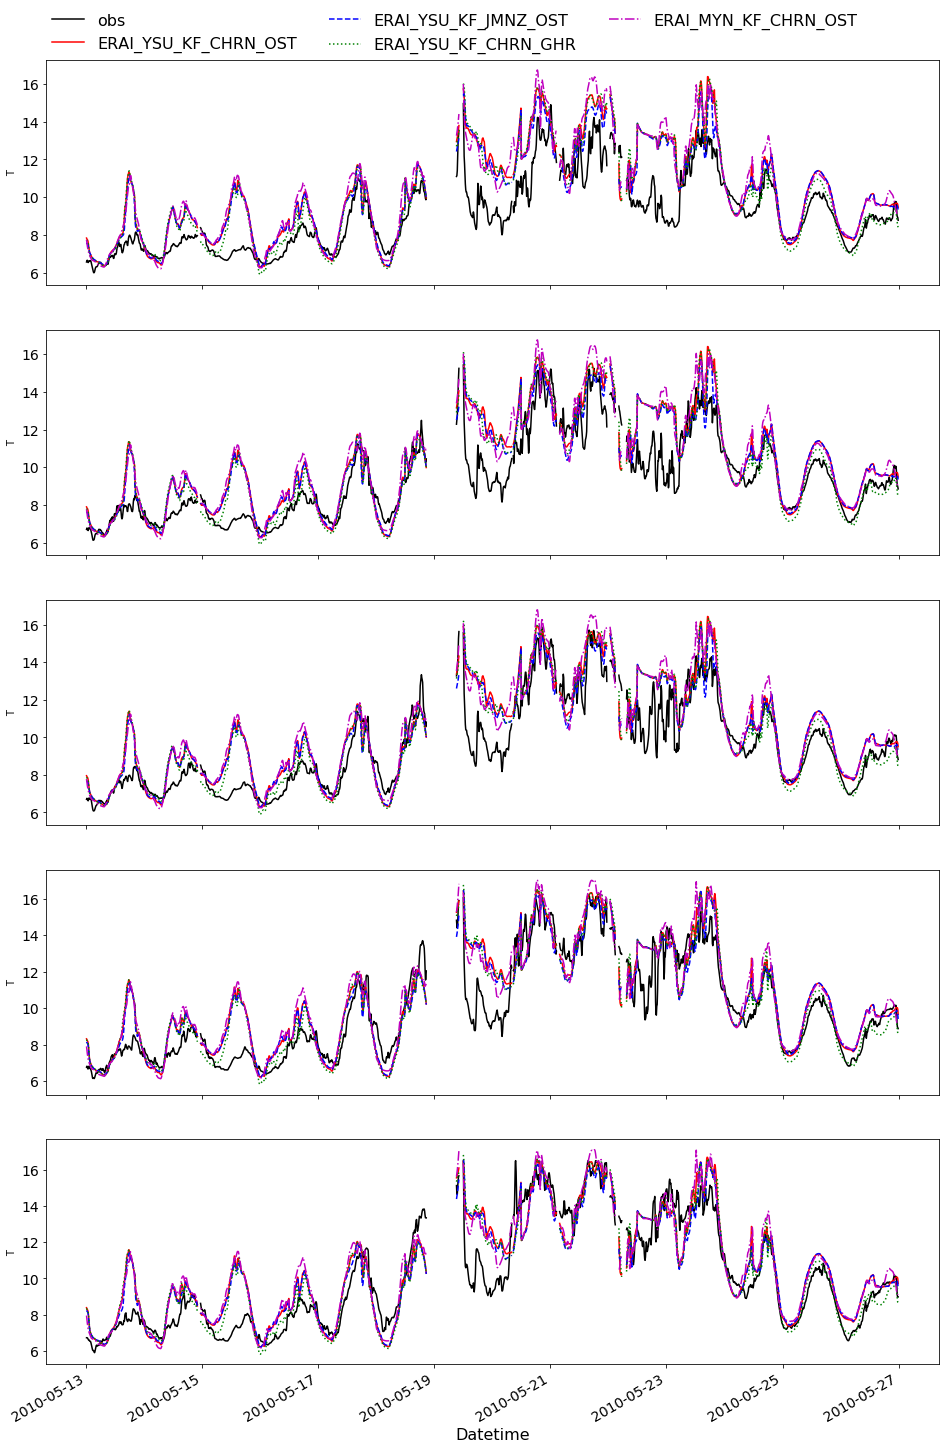

/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526//img/TD_FINO2_T_nowake


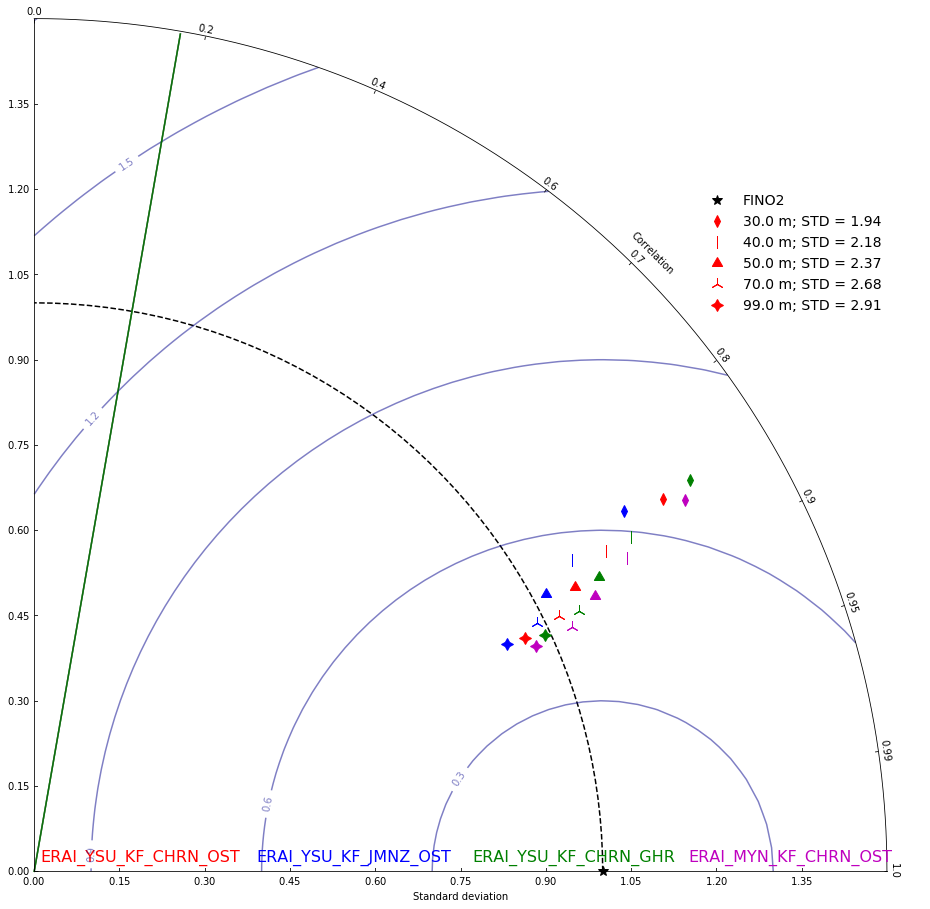

/glade/u/home/hawbecke/local/envs/pyhawbeck/lib/python3.7/site-packages/xarray/core/resample.py:174: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/glade/u/home/hawbecke/local/envs/pyhawbeck/lib/python3.7/site-packages/xarray/core/resample.py:174: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/glade/u/home/hawbecke/local/envs/pyhawbeck/lib/python3.7/site-packages/xarray/core/resample.py:174: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/

/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526//img/TD_data_FINO3_T_nowake


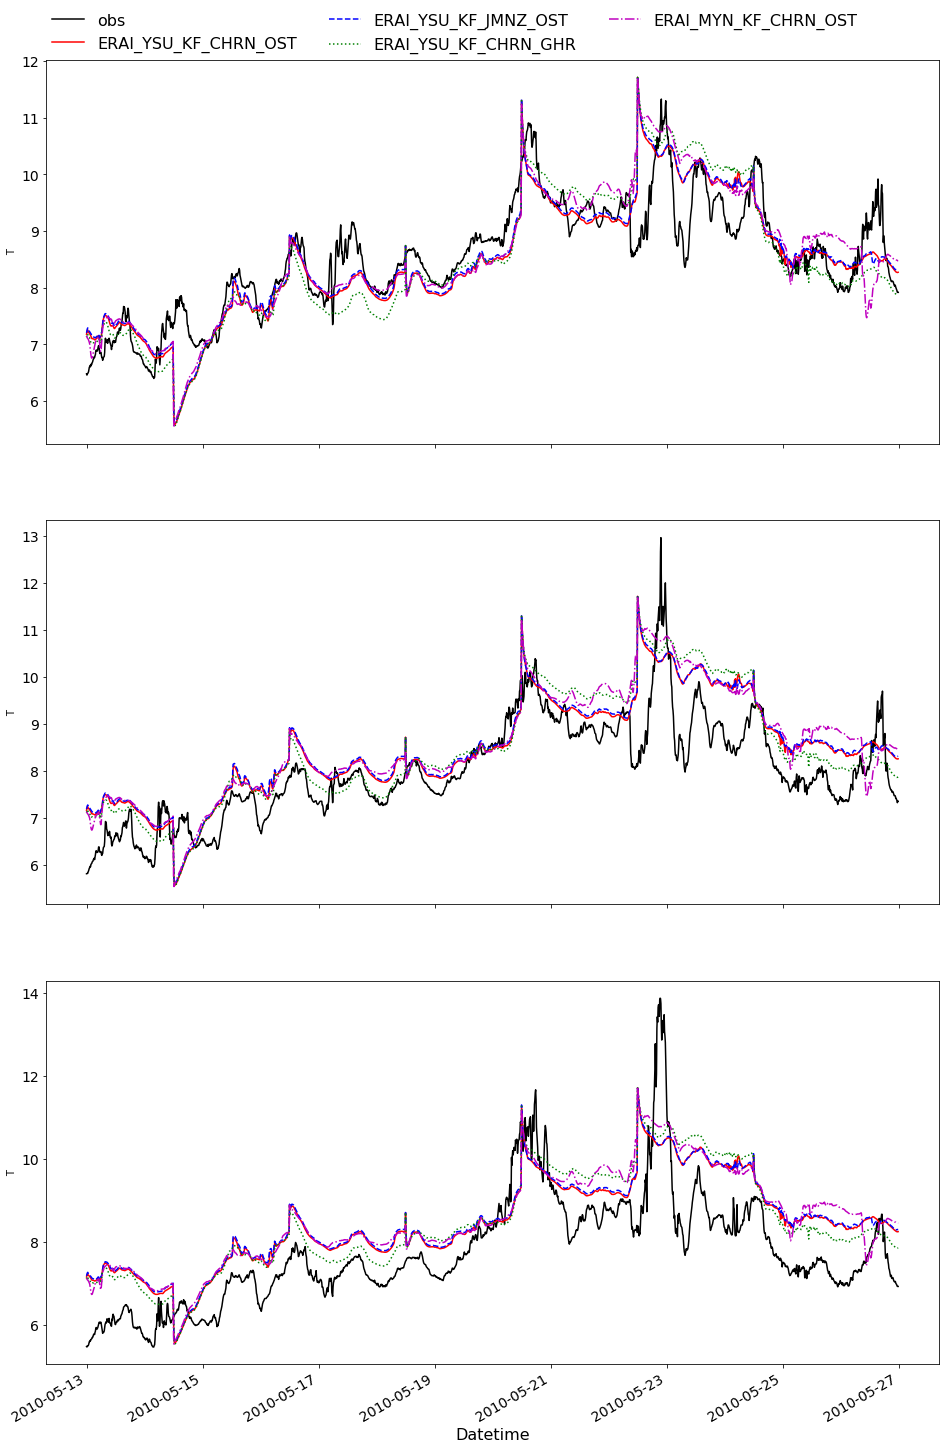

/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526//img/TD_FINO3_T_nowake


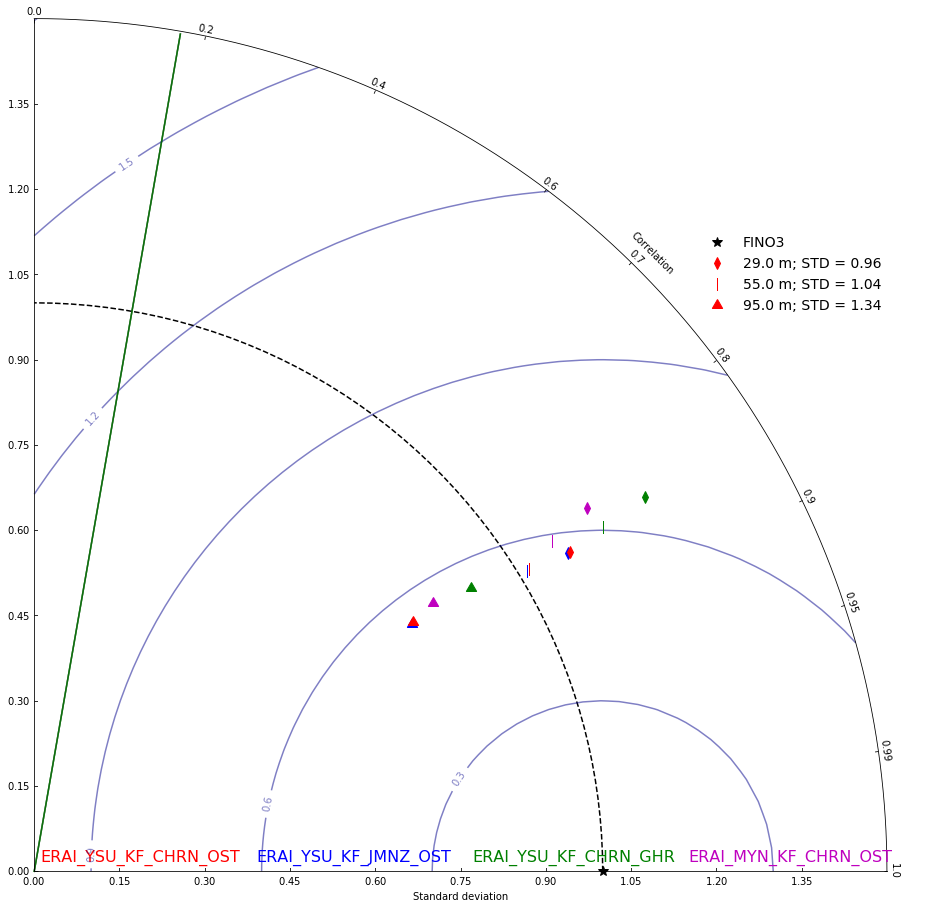

In [18]:
for ff, fino in enumerate([1,2,3]):
    obs_ds = fino_obs['FINO{}'.format(fino)]
    levels = obs_ds.tmp_levels.values
    obs_wdir = obs_ds.wdir
    max_pts = 0
    dir_lvl = 0
    for vv,lvl in enumerate(obs_wdir.dir_levels.values):
        dir_lvl = obs_wdir.sel(dir_levels=lvl).dropna(how='all',dim='datetime')
        num_pts = len(dir_lvl)
        if num_pts > max_pts:
            dir_lvl = lvl
    good_lvls = []
    for vv,lvl in enumerate(levels):
        if len(obs_ds.temp.sel(datetime=slice(case_days_start[0],case_days_end[0]),
                               tmp_levels=lvl).dropna(how='all',dim='datetime')) > 1:
            good_lvls.append(lvl)
    levels = good_lvls

    tay_obs_levels = [[[]]*len(levels)][0]
    ref_std_levels = np.zeros((ncases,len(levels)))
    sim_std_levels = np.zeros((ncases,len(levels)))
    sim_cor_levels = np.zeros((ncases,len(levels)))
    fig,ax = plt.subplots(nrows=len(levels),figsize=(16,24),sharex=True)
    for cc,case in enumerate(cases):
        twr_ds = wrf_twrs[case]['FN{}'.format(fino)]
        tay_wrf_levels = [[[]]*len(levels)][0]
        twr_ds['T'] = theta_to_T(twr_ds.theta,twr_ds.pr/100.0) - 273.15
        for vv,lvl in enumerate(levels):
            if cc == 0:
                tay_obs_levels[vv] = obs_ds.temp.sel(datetime=slice(case_days_start[0],case_days_end[0]),
                                                     tmp_levels=lvl).dropna(how='all',dim='datetime').resample(
                                                     datetime='10min').interpolate('linear')

                if remove_wake:
                    obs_wdir = obs_ds.wdir.sel(datetime=slice(case_days_start[0],case_days_end[0]),
                                               dir_levels=dir_lvl).dropna(how='all',dim='datetime').resample(
                                               datetime='10min').nearest()
                    wake_tmp = tay_obs_levels[vv].copy()
                    if fino == 2:
                        wake_tmp[np.where((obs_wdir.data >= wake_degs['FINO{}'.format(fino)][0]) | \
                                          (obs_wdir.data <= wake_degs['FINO{}'.format(fino)][1]))] = np.nan
                    else:
                        wake_tmp[np.where((obs_wdir.data >= wake_degs['FINO{}'.format(fino)][0]) & \
                                          (obs_wdir.data <= wake_degs['FINO{}'.format(fino)][1]))] = np.nan
                    tay_obs_levels[vv] = wake_tmp

            tay_wrf_levels[vv] = twr_ds.T.sel(datetime=slice(case_days_start[0],case_days_end[0]),nz=vv).dropna(
                                                how='all',dim='datetime').resample(datetime='10min').mean()
            if remove_wake:
                wake_tmp = tay_wrf_levels[vv].copy()
                wake_tmp[np.where(np.isnan(tay_obs_levels[vv]))] = np.nan
                tay_wrf_levels[vv] = wake_tmp

            obs = tay_obs_levels[vv]
            sim = tay_wrf_levels[vv]

            sim[np.where(np.isnan(obs))] = np.nan

            obs = obs.dropna(dim='datetime',how='all')
            sim = sim.dropna(dim='datetime',how='all')

            if remove_mean:
                obs = obs - lowess_mean(obs,2016/32,0)
                sim = sim - lowess_mean(sim,2016/32,0)

            if cc == 0: 
                obs.resample(datetime='10min').asfreq().plot(ax=ax[vv],c='k',label='obs')
            sim.resample(datetime='10min').asfreq().plot(ax=ax[vv],c=case_colors[cc],label=case,ls=case_style[cc])
            ax[vv].tick_params(labelsize=14)
            if vv == len(levels)-1:
                ax[vv].set_xlabel('Datetime',size=16)
            else:
                ax[vv].set_xlabel('')
            if remove_mean: ax[vv].set_ylim(-5,5)

            ref_std_levels[cc,vv] = np.std(obs.data)
            sim_std_levels[cc,vv] = np.std(sim.data)
            sim_cor_levels[cc,vv] = np.corrcoef(sim,obs)[0,1]
    ax[0].legend(frameon=False,loc=(0.0,1.0),ncol=3,fontsize=16)
    save_str = '{}/img/TD_data_FINO{}_T'.format(wrf_dir,fino)
    if remove_mean: save_str += '_pert'
    if remove_wake: save_str += '_nowake'
    print(save_str)
    if save_figs: plt.savefig('{}.png'.format(save_str))
    plt.show()
    


    fig_tay = plt.figure(figsize=(16,16))    
    dia = TaylorDiagram(1.0, fig=fig_tay, extend=False,
                            label='FINO{}'.format(fino))
    for cc,case in enumerate(cases):
        twr_dict = {}
        for a,b,c,d in zip(range(0,len(levels)),sim_std_levels[cc,:]/ref_std_levels[cc,:],sim_cor_levels[cc,:],levels):
            twr_dict[a] = [b,c,'{} m'.format(d)]



        x95 = [0.0, 0.89*(np.pi/2)]
        y95 = [0.0, 1.495]

        dia.ax.plot(x95,y95,color='darkgreen',alpha=0.5)
        markers = [(i,j,0) for i in range(2,len(levels)+2) for j in range(1, 3)]

        for ii,item in enumerate(twr_dict):
            point = twr_dict[item]
            if cc == 0:
                pt_label = '{0}; STD = {1:1.2f}'.format(point[2],ref_std_levels[cc,ii])
            else:
                pt_label = None
            dia.add_sample(point[0], point[1],
                           marker=markers[item], ms=12, ls='',
                           mfc=case_colors[cc], mec=case_colors[cc], # Colors
                           label=pt_label,
                           zorder=4)
        plt.text(0.01+0.38*cc,0.01,case,color=case_colors[cc],ha='left',va='bottom',size=16)

    contours = dia.add_contours(levels=5, colors='darkblue',alpha=0.5)
    dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    fig_tay.legend(frameon=False,loc=(0.75,0.65),fontsize=14)
    save_str = '{}/img/TD_FINO{}_T'.format(wrf_dir,fino)
    if remove_mean: save_str += '_pert'
    if remove_wake: save_str += '_nowake'
    print(save_str)
    if save_figs: plt.savefig('{}.png'.format(save_str))
    plt.show()
    
    